# Loan Default Prediction

In this scenario you are tasked with formulating a rule set to classify high-risk loan applicants (an applicant likely to fail to pay back a loan).  You are free to quantify what "high-risk" means and what types of rules are used.  The important thing is to _quantify the value of your rules_.

Therefore, an important part of our task is to quantify the effectiveness of the current practice (loan Grade and Subgrade).   Our conclusion should either propose changes that add value, or validate the current practice and show it is not practical to change it.   

This execise is inspired by the very recent release of Lending Club Loan Data from 2007-2015.  We will use it to build a Loan default predictor.  You can download the data here:

https://www.kaggle.com/wendykan/lending-club-loan-data

You can see the LendingClub website here:

https://www.lendingclub.com/

Check out "Browse Loans" to see how the business works.

I've left the code in this notebook as close as possible to my original first-pass, stream-of-conciousness analysis. 


In [1]:
import pandas
%matplotlib inline
# allows plotting in cells, we'll use later on.
import pylab
pylab.rcParams['figure.figsize'] = (10, 6) # set a larger figure size

Read the Excel data dictionary (it's nice to have it here).  You need to install the `xlrd` module first.  Windows: from the command prompt, go to your Anaconda python directory (you will see `python.exe` there) and:

`python -m pip install xlrd`  

Under Linux, from anywhere: `sudo -H python -m pip install xlrd`

In [2]:
import xlrd

In [3]:
df_dictionary = pandas.read_excel('C:/Users/peter/Documents/Codementor/MLClass/data/lendingclub/LCDataDictionary.xlsx')

In [4]:
df_dictionary

,LoanStatNew,Description
0,addr_state,The state provided by the borrower in the loan...
1,annual_inc,The self-reported annual income provided by th...
2,annual_inc_joint,The combined self-reported annual income provi...
3,application_type,Indicates whether the loan is an individual ap...
4,collection_recovery_fee,post charge off collection fee
5,collections_12_mths_ex_med,Number of collections in 12 months excluding m...
6,delinq_2yrs,The number of 30+ days past-due incidences of ...
7,desc,Loan description provided by the borrower
8,dti,A ratio calculated using the borrower’s total ...
9,dti_joint,A ratio calculated using the co-borrowers' tot...


In [5]:
df_dictionary.iloc[20].Description

u'The initial listing status of the loan. Possible values are \u2013 W, F'

In [5]:
import sqlite3
conn = sqlite3.connect('C:/Users/peter/Documents/Codementor/MLClass/data/lendingclub/database.sqlite')

Find out the table name(s)

In [6]:
query = """
SELECT name FROM sqlite_master WHERE type='table'
"""
response = conn.execute(query)
response.fetchall()

[(u'loan',)]

Get an idea of the data format

In [7]:
query = """
SELECT * FROM loan LIMIT 5
"""
df_sample = pandas.read_sql(query, conn)
with pandas.option_context('display.max_columns', 75):
    print df_sample

   index       id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0      0  1077501  1296599.0     5000.0       5000.0           4975.0   
1      1  1077430  1314167.0     2500.0       2500.0           2500.0   
2      2  1077175  1313524.0     2400.0       2400.0           2400.0   
3      3  1076863  1277178.0    10000.0      10000.0          10000.0   
4      4  1075358  1311748.0     3000.0       3000.0           3000.0   

         term int_rate  installment grade sub_grade                 emp_title  \
0   36 months   10.65%       162.87     B        B2                      None   
1   60 months   15.27%        59.83     C        C4                     Ryder   
2   36 months   15.96%        84.33     C        C5                      None   
3   36 months   13.49%       339.31     C        C1       AIR RESOURCES BOARD   
4   60 months   12.69%        67.79     B        B5  University Medical Group   

  emp_length home_ownership  annual_inc verification_status   issue_d  \
0

Is it one entry (id) for life of the loan?

In [8]:
df_sample.id[0]

u'1077501'

In [9]:
query = """
SELECT * FROM loan WHERE id = '1077501'
"""
df_sample = pandas.read_sql(query, conn)
df_sample

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,...,None,None,None,None,None,None,None,None,None,None


In [10]:
query = """
SELECT id,COUNT(*) as count FROM loan GROUP BY id ORDER BY count DESC;
"""
df_count = pandas.read_sql(query, conn)
df_count.head()

,id,count
0,1000007,1
1,1000030,1
2,1000033,1
3,1000045,1
4,1000067,1


Our classifier will be used to rate loans before funding, so we have to be careful to pick fields that were known at loan origination for our classifer.  At this point, we would need to have a discussion with the IT folks about what fields would qualify.  Let's assume they said every field is from loan origination, except: 
   * totals such as total_pymnt, total_rec_late_fee, etc.
   * last and next payment dates, last credit pull date

# Data selection and cleaning

The full database is 492MB.  It will fit entirely in memory. No real need to subset using a SQL query.  I like to explicitly select out columns I'm thinking of using right now.  It helps organize my thought process. 

The database read, from disk, takes about a minute.  From my SSD, a < 10 seconds.

Note From The Future: I ran into some `Memory Error` problems on my 32-bit, 6GB linux box.  I solved these by restarting the kernel and re-running the notebook.


In [11]:
query = """
SELECT 
    id,
    member_id,
    funded_amnt_inv,
    funded_amnt,
    int_rate,
    installment,
    grade,
    sub_grade,
    emp_length,
    home_ownership,
    annual_inc,
    issue_d,
    loan_status,
    purpose,
    desc,
    dti,
    earliest_cr_line,
    inq_last_6mths,
    mths_since_last_delinq,
    open_acc,
    revol_bal,
    revol_util,
    total_acc,
    total_pymnt,
    total_rec_prncp,
    total_rec_int,
    total_rec_late_fee,
    application_type

FROM loan
"""

df = pandas.read_sql(query, conn)

In [12]:
df.describe()

C:\Users\peter\Anaconda2\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,member_id,funded_amnt_inv,funded_amnt,installment,annual_inc,dti,inq_last_6mths,mths_since_last_delinq,open_acc,revol_bal,total_acc,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee
count,8.873820e+05,887382.000000,887382.000000,887382.000000,8.873780e+05,887382.00000,887353.000000,433069.000000,887353.000000,8.873820e+05,887353.000000,887382.000000,887382.000000,887382.000000,887382.000000
mean,3.500184e+07,14702.480039,14741.893147,436.717647,7.502761e+04,18.15702,0.694622,34.063697,11.548471,1.692076e+04,25.268032,7558.831876,5757.706058,1754.810042,0.396690
std,2.411336e+07,8442.107612,8429.898507,244.186619,6.469823e+04,17.19060,0.998447,21.884941,5.317310,2.242676e+04,11.840553,7871.238570,6625.433555,2095.368371,4.087818
min,7.047300e+04,0.000000,500.000000,15.670000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,7.354484e+07,35000.000000,35000.000000,1445.460000,9.500000e+06,9999.00000,33.000000,188.000000,90.000000,2.904836e+06,169.000000,57777.579870,35000.030000,24205.620000,358.680000


In [13]:
df.head()

,id,member_id,funded_amnt_inv,funded_amnt,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,mths_since_last_delinq,open_acc,revol_bal,revol_util,total_acc,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,application_type
0,1077501,1296599.0,4975.0,5000.0,10.65%,162.87,B,B2,10+ years,RENT,...,NaN,3.0,13648.0,83.7%,9.0,5861.071414,5000.00,861.07,0.00,INDIVIDUAL
1,1077430,1314167.0,2500.0,2500.0,15.27%,59.83,C,C4,< 1 year,RENT,...,NaN,3.0,1687.0,9.4%,4.0,1008.710000,456.46,435.17,0.00,INDIVIDUAL
2,1077175,1313524.0,2400.0,2400.0,15.96%,84.33,C,C5,10+ years,RENT,...,NaN,2.0,2956.0,98.5%,10.0,3003.653644,2400.00,603.65,0.00,INDIVIDUAL
3,1076863,1277178.0,10000.0,10000.0,13.49%,339.31,C,C1,10+ years,RENT,...,35.0,10.0,5598.0,21%,37.0,12226.302212,10000.00,2209.33,16.97,INDIVIDUAL
4,1075358,1311748.0,3000.0,3000.0,12.69%,67.79,B,B5,1 year,RENT,...,38.0,15.0,27783.0,53.9%,38.0,3242.170000,2233.10,1009.07,0.00,INDIVIDUAL


In [14]:
df.set_index('id', inplace=True)
df.head()

,member_id,funded_amnt_inv,funded_amnt,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,mths_since_last_delinq,open_acc,revol_bal,revol_util,total_acc,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,application_type
id,,,,,,,,,,,,,,,,,,,,,
1077501,1296599.0,4975.0,5000.0,10.65%,162.87,B,B2,10+ years,RENT,24000.0,...,NaN,3.0,13648.0,83.7%,9.0,5861.071414,5000.00,861.07,0.00,INDIVIDUAL
1077430,1314167.0,2500.0,2500.0,15.27%,59.83,C,C4,< 1 year,RENT,30000.0,...,NaN,3.0,1687.0,9.4%,4.0,1008.710000,456.46,435.17,0.00,INDIVIDUAL
1077175,1313524.0,2400.0,2400.0,15.96%,84.33,C,C5,10+ years,RENT,12252.0,...,NaN,2.0,2956.0,98.5%,10.0,3003.653644,2400.00,603.65,0.00,INDIVIDUAL
1076863,1277178.0,10000.0,10000.0,13.49%,339.31,C,C1,10+ years,RENT,49200.0,...,35.0,10.0,5598.0,21%,37.0,12226.302212,10000.00,2209.33,16.97,INDIVIDUAL
1075358,1311748.0,3000.0,3000.0,12.69%,67.79,B,B5,1 year,RENT,80000.0,...,38.0,15.0,27783.0,53.9%,38.0,3242.170000,2233.10,1009.07,0.00,INDIVIDUAL


# Data characterization

Let's first think about value.  We want to focus on an area where we can make an impact.  Where's the money?  This is the most important part of our analysis.

In [15]:
g = df.groupby(['grade', 'sub_grade'])
type(g)

pandas.core.groupby.DataFrameGroupBy

In [16]:
g.describe()

annual_inc           dti   funded_amnt  \
grade sub_grade                                                   
A     A1        count  2.291400e+04  22914.000000  22914.000000   
                mean   9.466800e+04     14.253122  13719.049489   
                std    6.064299e+04      6.925474   6638.770158   
                min    6.000000e+03      0.000000    725.000000   
                25%    6.000000e+04      9.020000   8300.000000   
                50%    8.200000e+04     13.750000  12000.000000   
                75%    1.124862e+05     19.110000  19000.000000   
                max    1.700000e+06     34.950000  29975.000000   
      A2        count  2.248400e+04  22485.000000  22485.000000   
                mean   8.677575e+04     15.166314  13438.329998   
                std    6.992632e+04      7.299234   7019.450000   
                min    3.500000e+03      0.000000   1000.000000   
                25%             NaN      9.660000   8000.000000   
                50%             NaN     14.700000  12000.000000   
                75%             NaN     20.320000  19000.000000   
                max    5.000010e+06     34.990000  34800.000000   
      A3        count  2.345500e+04  23457.000000  23457.000000   
                mean   8.736832e+04     15.679835  13880.305453   
                std    1.174188e+05      7.570715   7591.052749   
                min    3.300000e+03      0.000000    500.000000   
                25%             NaN      9.950000   8000.000000   
                50%             NaN     15.180000  12000.000000   
                75%             NaN     21.040000  20000.000000   
                max    9.000000e+06     39.700000  35000.000000   
      A4        count  3.453100e+04  34531.000000  34531.000000   
                mean   8.500143e+04     15.758522  14110.883699   
                std    7.732091e+04      7.464094   7786.866636   
                min    6.000000e+03      0.000000    500.000000   
                25%    5.040000e+04     10.190000   8000.000000   
                50%    7.200000e+04     15.230000  12000.000000   
...                             ...           ...           ...   
G     G2        std    5.363376e+04      8.284149   8834.810800   
                min    8.000000e+03      0.000000    600.000000   
                25%    4.800000e+04     13.715000  12881.250000   
                50%    6.500000e+04     19.710000  19400.000000   
                75%    8.987500e+04     25.290000  26937.500000   
                max    9.000000e+05     39.750000  35000.000000   
      G3        count  9.810000e+02    981.000000    981.000000   
                mean   8.124723e+04     18.856422  20817.609582   
                std    6.462231e+04      8.141983   8570.579953   
                min    1.896000e+03      0.000000   1800.000000   
                25%    4.964300e+04     12.910000  14400.000000   
                50%    6.500000e+04     18.790000  20000.000000   
                75%    9.300000e+04     24.380000  27800.000000   
                max    8.700000e+05     39.850000  35000.000000   
      G4        count  6.630000e+02    663.000000    663.000000   
                mean   8.580482e+04     18.879231  21186.123680   
                std    6.405152e+04      7.827982   8535.060740   
                min    8.796000e+03      0.530000   1200.000000   
                25%    5.000000e+04     13.165000  13712.500000   
                50%    7.000000e+04     18.900000  21200.000000   
                75%    1.000000e+05     24.540000  28000.000000   
                max    6.000000e+05     39.730000  35000.000000   
      G5        count  5.760000e+02    576.000000    576.000000   
                mean   8.892763e+04     18.644635  20954.861111   
                std    6.684127e+04      8.401049   8849.183469   
                min    1.100000e+04      0.000000   1600.000000   
                25%    5.500000e+04     12.477500  13912.500000   
     

Let's plot out the total received interest by grade & sub-grade; first understand the data structure we're creating

In [17]:
x=g['total_rec_int'].sum()
type(x)

pandas.core.series.Series

In [18]:
x

grade  sub_grade
A      A1           1.288429e+07
       A2           1.483234e+07
       A3           1.925414e+07
       A4           3.093603e+07
       A5           4.354043e+07
B      B1           4.495163e+07
       B2           5.849451e+07
       B3           7.577072e+07
       B4           8.079421e+07
       B5           6.643680e+07
C      C1           7.938202e+07
       C2           8.565343e+07
       C3           8.923623e+07
       C4           9.232545e+07
       C5           8.649048e+07
D      D1           7.476157e+07
       D2           6.581057e+07
       D3           6.162788e+07
       D4           6.658288e+07
       D5           5.969734e+07
E      E1           5.157045e+07
       E2           5.209222e+07
       E3           4.467452e+07
       E4           4.049532e+07
       E5           3.454093e+07
F      F1           2.791445e+07
       F2           2.246921e+07
       F3           1.866930e+07
       F4           1.557349e+07
       F5           1.2410

It's a Pandas series; therefore, it's got a plot() method.

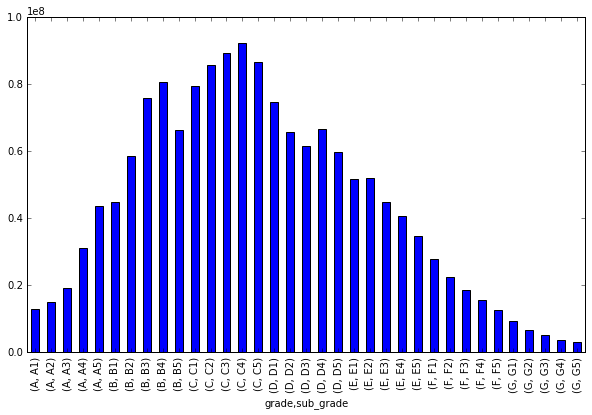

In [19]:
g['total_rec_int'].sum().plot(kind='bar')

Also plot the late fees collected.  It turns out-- not so much, compared to interest.

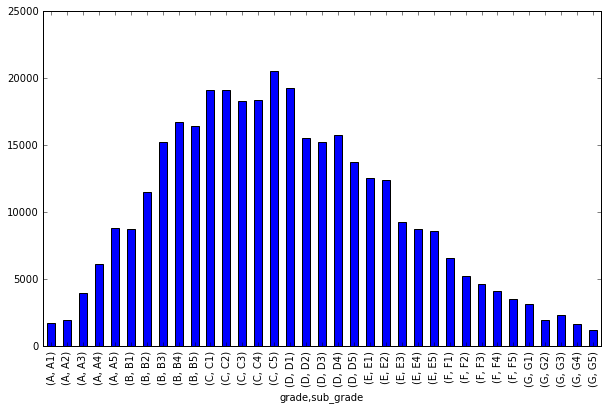

In [20]:
g['total_rec_late_fee'].sum().plot(kind='bar')

Most of the revenues are made from interest on the grade C loans. Not much money is made in late fees.  On the interest chart, there is an interesting sub-peak in B4-B5.  

Next we must realize that these are all data since 2007.  Has the money always been in C loans, or has that changed over time?

In [21]:
df.issue_d.unique()

array([u'Dec-2011', u'Nov-2011', u'Oct-2011', u'Sep-2011', u'Aug-2011',
       u'Jul-2011', u'Jun-2011', u'May-2011', u'Apr-2011', u'Mar-2011',
       u'Feb-2011', u'Jan-2011', u'Dec-2010', u'Nov-2010', u'Oct-2010',
       u'Sep-2010', u'Aug-2010', u'Jul-2010', u'Jun-2010', u'May-2010',
       u'Apr-2010', u'Mar-2010', u'Feb-2010', u'Jan-2010', u'Dec-2009',
       u'Nov-2009', u'Oct-2009', u'Sep-2009', u'Aug-2009', u'Jul-2009',
       u'Jun-2009', u'May-2009', u'Apr-2009', u'Mar-2009', u'Feb-2009',
       u'Jan-2009', u'Dec-2008', u'Nov-2008', u'Oct-2008', u'Sep-2008',
       u'Aug-2008', u'Jul-2008', u'Jun-2008', u'May-2008', u'Apr-2008',
       u'Mar-2008', u'Feb-2008', u'Jan-2008', u'Dec-2007', u'Nov-2007',
       u'Oct-2007', u'Sep-2007', u'Aug-2007', u'Jul-2007', u'Jun-2007',
       None, u'Dec-2013', u'Nov-2013', u'Oct-2013', u'Sep-2013',
       u'Aug-2013', u'Jul-2013', u'Jun-2013', u'May-2013', u'Apr-2013',
       u'Mar-2013', u'Feb-2013', u'Jan-2013', u'Dec-2012', u'Nov-2012',

Our loan issue dates are strings.  Best practice is to convert to a `date` or `datetime` type that Pandas understands.  To convert to a `datetime` from a string, see this reference: https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior

In [22]:
from datetime import datetime 
# slightly confusing; module and class have the same name
d = datetime.strptime("Dec-2011", "%b-%Y")
print d
print d.year

2011-12-01 00:00:00
2011


In [23]:
df['issue_datetime'] = df.issue_d.apply(
    lambda x: datetime.strptime(x, "%b-%Y") 
    if x is not None else datetime(1,1,1,0,0))

In [24]:
df['issue_year'] = df.issue_datetime.apply(lambda x: x.year)

In [25]:
df[['issue_d', 'issue_datetime', 'issue_year']].head()

,issue_d,issue_datetime,issue_year
id,,,
1077501,Dec-2011,2011-12-01 00:00:00,2011
1077430,Dec-2011,2011-12-01 00:00:00,2011
1077175,Dec-2011,2011-12-01 00:00:00,2011
1076863,Dec-2011,2011-12-01 00:00:00,2011
1075358,Dec-2011,2011-12-01 00:00:00,2011


In [26]:
g = df.groupby(['issue_year', 'grade'])

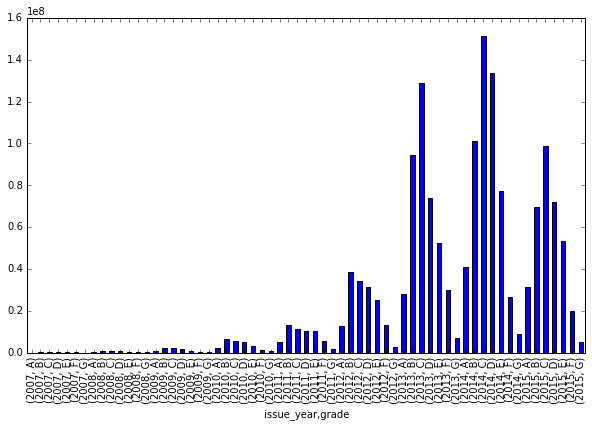

In [27]:
g['total_rec_int'].sum().plot(kind='bar')

In [28]:
g2 = g['total_rec_int'].sum()
g2.index


MultiIndex(levels=[[1, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], [u'A', u'B', u'C', u'D', u'E', u'F', u'G']],
           labels=[[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9], [0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6]],
           names=[u'issue_year', u'grade'])

In [29]:
type(g2)

pandas.core.series.Series

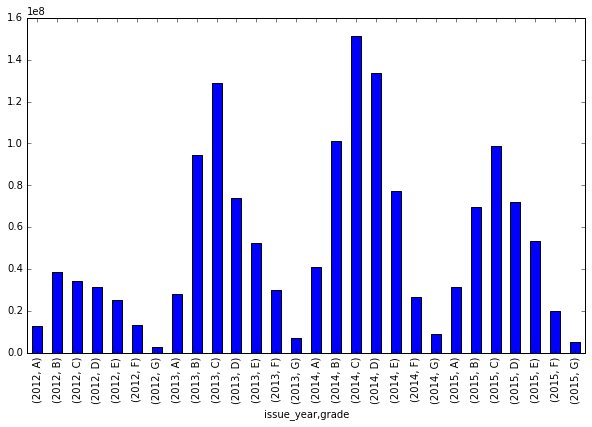

In [30]:
g2.loc[2012:2015].plot(kind='bar')

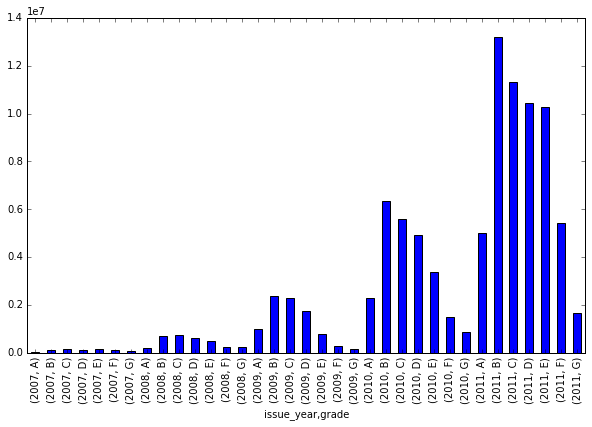

In [31]:
g2.loc[2007:2011].plot(kind='bar')

It appears there was a change in 2012-2013.  Since 2013, C-grade loans have generated the most interest revenue. There was also a dramatic increase in the overall business in 2013.  Models generally benefit from specificity.  Let's select out 2013 C-grade loans for our first model.

Older loans have a greater chance of default.  Since these data are from the end of 2015, using 2013 data will give us the chance for default within 2-3 years.

In [32]:
# conditions
c1 = df.issue_year == 2013
c2 = df.grade == 'C'

df_selected = df.loc[c1 & c2].copy()

In [33]:
df_selected[['grade', 'issue_datetime']].describe()

,grade,issue_datetime
count,38113,38113
unique,1,12
top,C,2013-10-01 00:00:00
freq,38113,4152


In [34]:
df_selected.head()

,member_id,funded_amnt_inv,funded_amnt,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,revol_bal,revol_util,total_acc,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,application_type,issue_datetime,issue_year
id,,,,,,,,,,,,,,,,,,,,,
10159584,12011200.0,9750.0,9750.0,13.98%,333.14,C,C1,1 year,RENT,26000.0,...,7967.0,52.8%,28.0,7994.83,6039.04,1955.79,0.0,INDIVIDUAL,2013-12-01 00:00:00,2013
10129403,11981032.0,7550.0,7550.0,16.24%,266.34,C,C5,3 years,RENT,28000.0,...,5759.0,72%,5.0,6407.38,4618.52,1788.86,0.0,INDIVIDUAL,2013-12-01 00:00:00,2013
10224583,12086734.0,11100.0,11100.0,14.98%,384.68,C,C3,10+ years,MORTGAGE,90000.0,...,6619.0,66.2%,12.0,9231.84,6837.40,2394.44,0.0,INDIVIDUAL,2013-12-01 00:00:00,2013
10148818,12000415.0,15000.0,15000.0,14.47%,516.10,C,C2,10+ years,RENT,98000.0,...,5749.0,22.3%,16.0,15699.03,14999.99,699.04,0.0,INDIVIDUAL,2013-12-01 00:00:00,2013
10089634,11941167.0,20000.0,20000.0,16.24%,488.92,C,C5,3 years,RENT,72000.0,...,20480.0,72.1%,32.0,11733.97,6140.23,5593.74,0.0,INDIVIDUAL,2013-12-01 00:00:00,2013


Let's solidify what we are going to predict.  This is known as the target variable.

In [35]:
df_selected.loan_status.unique()

array([u'Current', u'Fully Paid', u'Charged Off', u'Late (31-120 days)',
       u'Late (16-30 days)', u'In Grace Period', u'Default'], dtype=object)

Since the classifier we're using is binary (predicts a zero or one, given the input data), we'll need to encode our target variable, the loan status.

In [36]:
def map_status(status):
    label = 1 if status in ('Current', 'Fully Paid', 'In Grace Period') else 0
    return label

In [37]:
df_selected['target'] = df_selected.loan_status.map(map_status)

In [38]:
df_selected[['loan_status', 'target']].head(30)

,loan_status,target
id,,
10159584,Current,1
10129403,Current,1
10224583,Current,1
10148818,Fully Paid,1
10089634,Current,1
10109669,Fully Paid,1
8617375,Charged Off,0
10099585,Current,1
10109703,Current,1


# Model build

# Prepare data for machine learning algorithms

I have decision trees in mind, which makes life easier.  We can mix numerical and categorical data.  We don't need to scale or normalize.  Decision trees divide the dataset according to rules such as "dti < 17.2" etc.  Decision trees are also very dependable and understandable.  I like to use them as a starting point whenever possible.

For a  first pass, let's include only numerical data and drop NAs.  Categorical/cardinal data will require some extra pre-processing.
I'm also going to add a composite metric called 'loan bigness', simply
the monthly installment divided by the monthly income.

In [39]:
import numpy as np

columns = [
        'funded_amnt', # num
        'installment', # num
        'annual_inc', # num
        'dti', # num
        'open_acc', # num
        'revol_bal', # num
        'inq_last_6mths', # num
        'mths_since_last_delinq', # num
        'target'
        #'emp_length', # cardinal
        #'home_ownership', # categorical
        #'purpose' # categorical 
    ]

all_data = df_selected[columns].copy()
all_data['loan_bigness'] = all_data.installment / (all_data.annual_inc / 12.0) # generates some inf
all_data.replace([np.inf, -np.inf], np.nan, inplace=True)
all_data = all_data.dropna() # dropNA's eliminates about half the training data

# prepare the target (what we're going to predict)
all_input = all_data.drop('target', 1)
all_target = all_data.target.copy()



In [40]:
all_input.describe()

,funded_amnt,installment,annual_inc,dti,open_acc,revol_bal,inq_last_6mths,mths_since_last_delinq,loan_bigness
count,17129.000000,17129.000000,1.712900e+04,17129.000000,17129.000000,17129.000000,17129.000000,17129.000000,17129.000000
mean,14580.423551,442.986312,7.369360e+04,17.395184,11.308891,14791.527818,0.825617,34.216183,0.080180
std,8145.559811,248.068337,4.537303e+04,7.581871,4.588666,16669.491637,1.031162,21.545351,0.038533
min,1000.000000,34.030000,9.729000e+03,0.000000,1.000000,0.000000,0.000000,0.000000,0.001711
25%,8400.000000,279.720000,4.700000e+04,11.680000,8.000000,6509.000000,0.000000,16.000000,0.051508
50%,12250.000000,386.760000,6.500000e+04,17.000000,11.000000,11032.000000,1.000000,31.000000,0.075176
75%,20000.000000,538.400000,8.800000e+04,23.020000,14.000000,18457.000000,1.000000,49.000000,0.105177
max,35000.000000,1252.560000,1.300000e+06,34.990000,62.000000,509875.000000,6.000000,149.000000,0.193254


In [41]:
all_target.describe()

count    17129.000000
mean         0.871855
std          0.334261
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: target, dtype: float64

In [42]:
all_target.index

Index([u'10224583', u'10109669', u'8617375', u'10099585', u'10109703',
       u'10117493', u'10159475', u'10119428', u'10099426', u'10139417',
       ...
       u'2308283', u'2476873', u'2476859', u'2485947', u'2484781', u'2445224',
       u'2383167', u'2382039', u'2381883', u'2371355'],
      dtype='object', name=u'id', length=17129)

In [43]:
from sklearn.cross_validation import train_test_split
train_data, test_data, train_target, test_target = train_test_split(all_input, all_target, test_size=0.2)

In [44]:
?train_test_split

In [45]:
train_data.head()

,funded_amnt,installment,annual_inc,dti,open_acc,revol_bal,inq_last_6mths,mths_since_last_delinq,loan_bigness
id,,,,,,,,,
7093038,17800.0,622.38,50000.0,15.83,14.0,14198.0,0.0,17.0,0.149371
8608724,7000.0,240.27,45000.0,5.47,14.0,9137.0,2.0,31.0,0.064072
5155064,30000.0,1059.02,90000.0,21.41,18.0,27399.0,0.0,28.0,0.141203
9215866,29700.0,1047.10,96000.0,23.57,16.0,21148.0,2.0,62.0,0.130887
7096763,28000.0,692.57,71000.0,20.59,36.0,11778.0,1.0,69.0,0.117054


In [46]:
test_data.head()

,funded_amnt,installment,annual_inc,dti,open_acc,revol_bal,inq_last_6mths,mths_since_last_delinq,loan_bigness
id,,,,,,,,,
8375078,3000.0,105.77,40000.0,4.32,6.0,4316.0,0.0,74.0,0.031731
3625782,11000.0,393.66,34000.0,33.39,6.0,10636.0,0.0,75.0,0.138939
7052051,16000.0,381.48,66000.0,25.04,12.0,9622.0,0.0,43.0,0.069360
7697320,7000.0,240.27,40000.0,17.85,11.0,5346.0,2.0,44.0,0.072081
5785195,7925.0,275.93,50000.0,17.66,12.0,7924.0,0.0,41.0,0.066223


In [47]:
test_data.loan_bigness.describe()

count    3426.000000
mean        0.079550
std         0.038717
min         0.001711
25%         0.051194
50%         0.074905
75%         0.104368
max         0.193254
Name: loan_bigness, dtype: float64

Let's have a look at how many good/bad loans we have in the testing an training sets

In [48]:
train_target.describe() # looks like 13% bad loans

count    13703.000000
mean         0.870758
std          0.335480
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: target, dtype: float64

In [49]:
test_target.describe() # similar percentage of bad loans

count    3426.000000
mean        0.876241
std         0.329355
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: target, dtype: float64

We have a low percentage of bad loans.  Keep this in mind when we evaluate our classifier.  If we just say, "all grade 2013 C loans are good", we will be 87% accurate.  

In [50]:
train_target.index[0:5], train_data.index[0:5] # just checking :)

(Index([u'7093038', u'8608724', u'5155064', u'9215866', u'7096763'], dtype='object', name=u'id'),
 Index([u'7093038', u'8608724', u'5155064', u'9215866', u'7096763'], dtype='object', name=u'id'))

In [51]:
test_target.index[0:5], test_data.index[0:5]

(Index([u'8375078', u'3625782', u'7052051', u'7697320', u'5785195'], dtype='object', name=u'id'),
 Index([u'8375078', u'3625782', u'7052051', u'7697320', u'5785195'], dtype='object', name=u'id'))

In [52]:
# if you want to re-run this including categorical variables, you can start here to figure out what needs to be encoded
#print df_train.emp_length.unique()
#print df_train.home_ownership.unique()
#print df_train.purpose.unique()

## Feature Selection

A subject-matter expert (SME) is usually the best feature selector.  Automated feature selection is also important.  Automated selection is best used to validate and/or enhance the SME's advice.  Scikit learn has a variety of feature selectors.  We will try a few here.  Reference:

http://scikit-learn.org/stable/modules/feature_selection.html


### ExtraTreesClassifier

This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier



In [52]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier

In [53]:
forest = ExtraTreesClassifier(n_estimators=100)
forest.fit(train_data, train_target)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Following was adapted to our problem from this example:
http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#example-ensemble-plot-forest-importances-py

In [55]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [56]:
indices

array([3, 8, 5, 7, 2, 1, 4, 0, 6], dtype=int64)

In [57]:
train_data.columns[indices]  # names

Index([u'dti', u'loan_bigness', u'revol_bal', u'mths_since_last_delinq',
       u'annual_inc', u'installment', u'open_acc', u'funded_amnt',
       u'inq_last_6mths'],
      dtype='object')

In [58]:
# Print the feature ranking
print("Feature ranking:")

for f in range(train_data.shape[1]):
    print("%d. %s (%f)" % (f + 1, train_data.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. dti (0.128589)
2. loan_bigness (0.125279)
3. revol_bal (0.124713)
4. mths_since_last_delinq (0.123464)
5. annual_inc (0.116176)
6. installment (0.114957)
7. open_acc (0.113509)
8. funded_amnt (0.106221)
9. inq_last_6mths (0.047091)


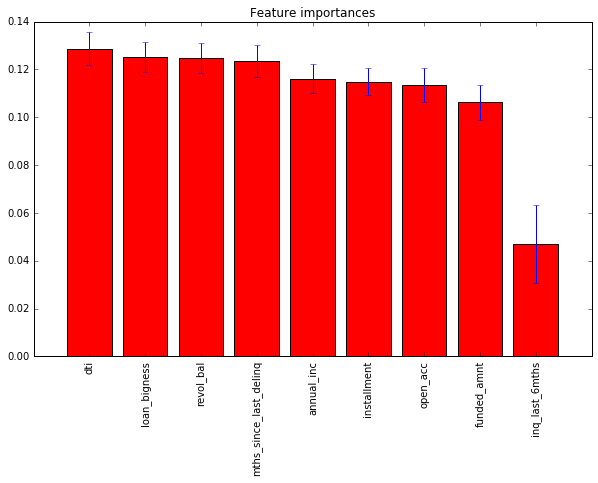

In [59]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_data.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train_data.shape[1]), train_data.columns[indices], rotation=90)
plt.xlim([-1, train_data.shape[1]])
plt.show()

let's go with `dti`, `revol_bal`, `loan_bigness`, and `mths_since_last_delinq` for our initial model

In [60]:
model_features=['dti', 'revol_bal', 'loan_bigness', 'mths_since_last_delinq']

train_data = train_data[model_features].copy()
test_data = test_data[model_features].copy()

train_data.head()

,dti,revol_bal,loan_bigness,mths_since_last_delinq
id,,,,
7093038,15.83,14198.0,0.149371,17.0
8608724,5.47,9137.0,0.064072,31.0
5155064,21.41,27399.0,0.141203,28.0
9215866,23.57,21148.0,0.130887,62.0
7096763,20.59,11778.0,0.117054,69.0


## Train the Model
It's rather anti-climatic.

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Train a logistic regression classifier

In [61]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_data, train_target)
lr_probs = lr.predict_proba(test_data)

In [62]:
lr_probs

array([[ 0.16835303,  0.83164697],
       [ 0.042451  ,  0.957549  ],
       [ 0.10182108,  0.89817892],
       ..., 
       [ 0.39843778,  0.60156222],
       [ 0.12731471,  0.87268529],
       [ 0.0993695 ,  0.9006305 ]])

Train a random forest classifier

In [63]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
rf = RandomForestClassifier(n_estimators=100, max_depth=2, max_features=3)

In [66]:
rf.fit(train_data, train_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features=3, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Let's have a look at the decision trees we've trained!

In [67]:
len(rf.estimators_)

100

In [68]:
rf.estimators_[0]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=3, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1369645486, splitter='best')

As expected, our random forest consists of 101 DecisionTreeClassifiers.

In [69]:
from sklearn.tree import export_graphviz
export_graphviz(rf.estimators_[0], out_file='C:/Users/peter/Documents/Codementor/MLClass/small_tree0.dot')

In [70]:
export_graphviz(rf.estimators_[1], out_file='C:/Users/peter/Documents/Codementor/MLClass/small_tree1.dot')

To view this file: install Graphviz viewer
    http://www.graphviz.org/
    
Gini impurity is $1 - \Sigma p_i ^2$. Zero means there is only one class in the set (the probability of being in that class is 100%.)  Gini impurity is maximized when the chances for each class are equal.  In this case, with two classes, it's $1 - (0.5^2 + 0.5^2) = 1 - 0.5 = 0.5$.  For our 2013 data, it's 87% good loans, so Gini = $1 - 0.87^2 - 0.13^2 = 0.226$.

## Use the model to classify our test (future) data

In [71]:
test_data.describe()

,dti,revol_bal,loan_bigness,mths_since_last_delinq
count,3426.000000,3426.000000,3426.000000,3426.000000
mean,17.233818,14799.111792,0.079550,34.623468
std,7.548289,18446.488268,0.038717,21.886717
min,0.130000,0.000000,0.001711,0.000000
25%,11.530000,6466.500000,0.051194,16.000000
50%,16.870000,10953.500000,0.074905,31.000000
75%,22.847500,18162.750000,0.104368,50.000000
max,34.990000,509875.000000,0.193254,119.000000


Query predictive model with all test data, for purposes of testing
the effectiveness

In [72]:
probs = rf.predict_proba(test_data)
probs

array([[ 0.10403037,  0.89596963],
       [ 0.17413309,  0.82586691],
       [ 0.12487506,  0.87512494],
       ..., 
       [ 0.10577174,  0.89422826],
       [ 0.11745131,  0.88254869],
       [ 0.11366192,  0.88633808]])

Query an individual loan applicant

In [73]:
rf.predict(np.array([105.0, 2000000, 0.21, 1]).reshape(1,-1))

array([1], dtype=int64)

# Model evaluation
Receiver operating characteristic curves are almost always the best way to evaluate if your classifier is actually working.

Justification: http://www.hpl.hp.com/techreports/2003/HPL-2003-4.pdf

I encourage you to test and explore the conslusions of that paper.
I feel there are too many bad examples of model evaluation online.  The paper will get you going in the right direction.

Let's see what the ROC curve says about our classifier.  We'll also check out AUC (**A**rea **U**nder the roc **C**urve), a related metric.

In [74]:
from sklearn.metrics import roc_curve, auc

In [76]:
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(test_target, probs[:, 1])
roc_auc = auc(fpr, tpr)
print roc_auc


0.581942227194


Next one is for evaluating the logistic regression

In [77]:
# Compute ROC curve and area the curve
fpr_lr, tpr_lr, thresholds_lr = roc_curve(test_target, lr_probs[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)
print roc_auc_lr


0.468505273214


In [78]:
fpr

array([ 0.        ,  0.00707547,  0.00707547,  0.01415094,  0.01415094,
        0.0259434 ,  0.0259434 ,  0.05188679,  0.05188679,  0.05188679,
        0.06132075,  0.06132075,  0.06603774,  0.06603774,  0.06603774,
        0.06603774,  0.07311321,  0.07783019,  0.08254717,  0.08490566,
        0.08490566,  0.08490566,  0.08490566,  0.11320755,  0.11556604,
        0.11556604,  0.11556604,  0.11792453,  0.11792453,  0.11792453,
        0.11792453,  0.11792453,  0.12028302,  0.12028302,  0.12028302,
        0.15330189,  0.15330189,  0.15330189,  0.15330189,  0.15330189,
        0.15330189,  0.15330189,  0.15330189,  0.15330189,  0.15330189,
        0.15330189,  0.15330189,  0.15801887,  0.15801887,  0.15801887,
        0.15801887,  0.15801887,  0.15801887,  0.16037736,  0.16037736,
        0.16037736,  0.16509434,  0.16509434,  0.16509434,  0.16509434,
        0.16745283,  0.16745283,  0.16745283,  0.16745283,  0.17688679,
        0.17688679,  0.17688679,  0.17688679,  0.17688679,  0.17

In [79]:
thresholds

array([ 1.89644524,  0.89644524,  0.89627328,  0.89596963,  0.89594762,
        0.89584638,  0.89579768,  0.89562252,  0.89550018,  0.89545056,
        0.89537077,  0.89534876,  0.89530663,  0.89513467,  0.8951249 ,
        0.89507328,  0.89505098,  0.89502366,  0.89502155,  0.89500471,
        0.89483275,  0.89480901,  0.89470777,  0.89470692,  0.89459767,
        0.89457537,  0.89454563,  0.89453497,  0.89452604,  0.89442086,
        0.89440584,  0.89425055,  0.89422826,  0.89420931,  0.89412699,
        0.89410806,  0.89407003,  0.89398799,  0.89397651,  0.89391236,
        0.89390119,  0.89373863,  0.89368051,  0.89363274,  0.8936294 ,
        0.89361044,  0.89343849,  0.89342301,  0.89340702,  0.89338913,
        0.89333496,  0.8933135 ,  0.89331266,  0.89330233,  0.89320611,
        0.89308165,  0.89306566,  0.89305492,  0.89301158,  0.89282686,
        0.89282415,  0.89281558,  0.89280732,  0.89280543,  0.8927138 ,
        0.89268583,  0.89263347,  0.89250693,  0.8924668 ,  0.89

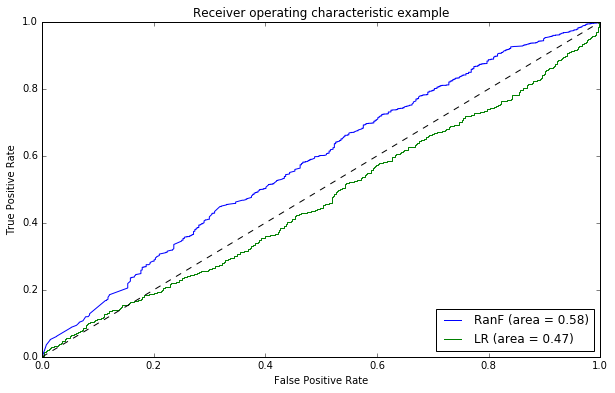

In [80]:
# Plot ROC curve
plt.clf()
plt.plot(fpr, tpr, label='RanF (area = %0.2f)' % roc_auc)
plt.plot(fpr_lr, tpr_lr, label='LR (area = %0.2f)' % roc_auc_lr)
#pl.plot(fpr2, tpr2, label='KNN(3) (area = %0.2f)' % roc_auc2)
#pl.plot(fpr3, tpr3, label='KNN(21) (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

If our classifier was doing a great job (it's not), the blue line would move up and left.  The AUC would increase well above 0.50.

Just to drive the point home about using ROC curves and AUC instead of the built-in accuracy metric:

In [81]:
rf.score(test_data, test_target)

0.87624051371862233

# Conclusion

Our ROC curve suggests we can predict that some C-grade loans will have a greater chance of default.  The next steps are to further verify and optimize our model. (Different settings for the random forest parameters; inclusion or removal of different input data variables). Sci-kit learn has a pipeline and grid search object for this specific purpose.  You will also want to learn about cross-validation.

In [228]:
np.logspace(-4, 4, 3)

array([  1.00000000e-04,   1.00000000e+00,   1.00000000e+04])